In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_ads.csv')
df


,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click,age_group
0,670,User670,22.0,Female,Desktop,Top,Shopping,Afternoon,1,18-24
1,3044,User3044,34.0,Male,Desktop,Top,News,Night,1,25-44
2,5912,User5912,41.0,Non-Binary,Mobile,Side,Education,Night,1,25-44
3,5418,User5418,34.0,Male,Mobile,Top,Entertainment,Evening,1,25-44
4,9452,User9452,39.0,Female,Mobile,Top,Other,Morning,0,25-44
...,...,...,...,...,...,...,...,...,...,...
3995,9540,User9540,64.0,Male,Mobile,Side,Other,Evening,0,60+
3996,8510,User8510,42.0,Female,Mobile,Top,Education,Morning,0,25-44
3997,7843,User7843,37.0,Female,Desktop,Bottom,Entertainment,Morning,0,25-44
3998,3914,User3914,43.0,Male,Mobile,Side,Social Media,Morning,0,25-44


In [ ]:
for col in df.columns:
  if col not in ['id','full_name','age']:
    print(f"Column '{col}':")
    print(df[col].value_counts())
    print("-" * 20)


Column 'gender':
gender
Female        1641
Male          1619
Non-Binary     740
Name: count, dtype: int64
--------------------
Column 'device_type':
device_type
Mobile     1645
Tablet     1450
Desktop     905
Name: count, dtype: int64
--------------------
Column 'ad_position':
ad_position
Top       1463
Bottom    1429
Side      1108
Name: count, dtype: int64
--------------------
Column 'browsing_history':
browsing_history
News             1470
Social Media      908
Other             690
Entertainment     324
Education         308
Shopping          300
Name: count, dtype: int64
--------------------
Column 'time_of_day':
time_of_day
Evening      1235
Night        1054
Morning       947
Afternoon     764
Name: count, dtype: int64
--------------------
Column 'click':
click
0    3500
1     500
Name: count, dtype: int64
--------------------
Column 'age_group':
age_group
25-44    2746
45-59     724
18-24     302
60+       228
Name: count, dtype: int64
--------------------


In [ ]:
# Train test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=666)
df_train.shape, df_test.shape


((3200, 10), (800, 10))

In [ ]:
# Load dataset (assuming df_train and df_test are already loaded)
# Feature selection
X_train = df_train.drop(['id', 'full_name', 'age_group', 'click'], axis=1)
y_train = df_train['click']
X_test = df_test.drop(['id', 'full_name', 'age_group', 'click'], axis=1)
y_test = df_test['click']

# Identify categorical columns
categorical_cols = ['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']

# Apply One-Hot Encoding
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure columns in X_train and X_test match
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply undersampling to handle class imbalance
undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)


# 2. Build ML models

In [ ]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Train and evaluate baseline models
results = {}

for name, model in models.items():
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train, y_train_resampled)

    # Predict
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probability of click=1

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    results[name] = {
        "accuracy": accuracy,
        "auc": auc,
        "classification_report": report,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

    print(f"{name} Training Completed!")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print("Classification Report:\n", report)
    print("=" * 50)

Training Logistic Regression...
Logistic Regression Training Completed!
Accuracy: 0.5975
AUC Score: 0.6650
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.58      0.72       710
           1       0.18      0.70      0.28        90

    accuracy                           0.60       800
   macro avg       0.56      0.64      0.50       800
weighted avg       0.85      0.60      0.67       800

Training SVM...
SVM Training Completed!
Accuracy: 0.7850
AUC Score: 0.7010
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.88       710
           1       0.19      0.29      0.23        90

    accuracy                           0.79       800
   macro avg       0.55      0.57      0.55       800
weighted avg       0.82      0.79      0.80       800



In [ ]:
# Hyperparameter Tuning for Random Forest, XGBoost, LightGBM
tuned_models = {}

# Random Forest Tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, n_iter=5, cv=3, scoring="roc_auc", verbose=2, n_jobs=-1)
rf_search.fit(X_train, y_train_resampled)
tuned_models["Random Forest"] = rf_search.best_estimator_


Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [ ]:
# XGBoost Tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_param_grid, n_iter=5, cv=3, scoring="roc_auc", verbose=2, n_jobs=-1)
xgb_search.fit(X_train, y_train_resampled)
tuned_models["XGBoost"] = xgb_search.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:51:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# LightGBM Tuning
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [20, 30, 40],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
lgb_search = RandomizedSearchCV(LGBMClassifier(random_state=42), lgb_param_grid, n_iter=5, cv=3, scoring="roc_auc", verbose=2, n_jobs=-1)
lgb_search.fit(X_train, y_train_resampled)
tuned_models["LightGBM"] = lgb_search.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 410, number of negative: 820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 1230, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


In [ ]:
# Evaluate Tuned Models
for name, model in tuned_models.items():
    print(f"Evaluating {name}...")

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    results[name] = {
        "accuracy": accuracy,
        "auc": auc,
        "classification_report": report
    }

    print(f"✅ {name} Evaluation Completed!")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print("Classification Report:\n", report)
    print("=" * 50)

Evaluating Random Forest...
✅ Random Forest Evaluation Completed!
Accuracy: 0.8425
AUC Score: 0.7081
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.91       710
           1       0.07      0.03      0.05        90

    accuracy                           0.84       800
   macro avg       0.48      0.49      0.48       800
weighted avg       0.79      0.84      0.82       800

Evaluating XGBoost...
✅ XGBoost Evaluation Completed!
Accuracy: 0.7800
AUC Score: 0.7048
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       710
           1       0.20      0.31      0.24        90

    accuracy                           0.78       800
   macro avg       0.55      0.58      0.56       800
weighted avg       0.83      0.78      0.80       800

Evaluating LightGBM...
✅ LightGBM Evaluation Completed!
Accuracy: 0.7562
AUC Score: 0.6955
Classification Re

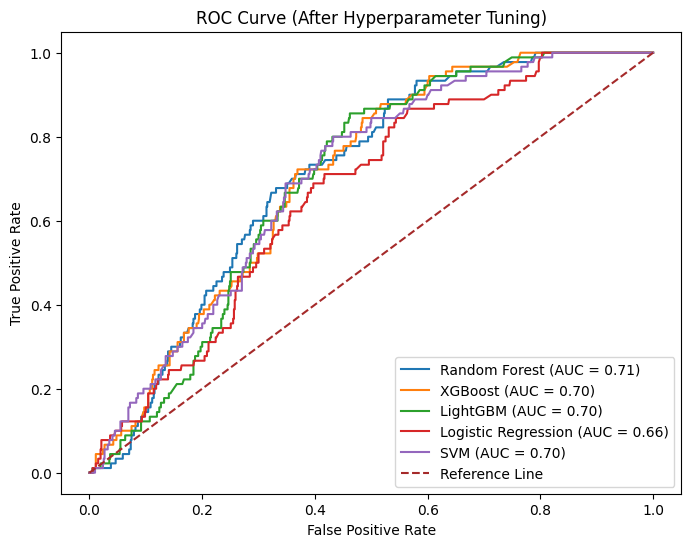

In [ ]:
plt.figure(figsize=(8, 6))

# Iterate over all models and plot their ROC curves
for name, model in tuned_models.items():  # Using tuned models (RF, XGB, LGBM)
    y_prob = model.predict_proba(X_test)[:, 1]  # Get click=1 probabilities
    fpr, tpr, _ = roc_curve(y_test, y_prob)  # Compute FPR & TPR
    auc = roc_auc_score(y_test, y_prob)  # Compute AUC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

for name, model in models.items():  # Including baseline models (Logistic, SVM)
    y_prob = model.predict_proba(X_test)[:, 1]  # Get click=1 probabilities
    fpr, tpr, _ = roc_curve(y_test, y_prob)  # Compute FPR & TPR
    auc = roc_auc_score(y_test, y_prob)  # Compute AUC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

# Add reference diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color="brown", label="Reference Line")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (After Hyperparameter Tuning)")
plt.legend()
plt.show()


In [ ]:
# Generate Random Test Sample
import random
random_data = {
    "gender": random.choice(["Male", "Female", "Non-Binary"]),
    "device_type": random.choice(["Mobile", "Desktop", "Tablet"]),
    "ad_position": random.choice(["Top", "Side", "Bottom"]),
    "browsing_history": random.choice(["Shopping", "News", "Education", "Entertainment", "Other", "Social Media"]),
    "time_of_day": random.choice(["Morning", "Afternoon", "Evening", "Night"]),
    "age": random.randint(18, 70)
}
random_df = pd.DataFrame([random_data])
random_df = pd.get_dummies(random_df, columns=categorical_cols, drop_first=True)
random_df = random_df.reindex(columns=X_train.columns, fill_value=0)
random_scaled = scaler.transform(random_df)


In [ ]:
random_data

{'gender': 'Non-Binary',
 'device_type': 'Tablet',
 'ad_position': 'Side',
 'browsing_history': 'News',
 'time_of_day': 'Morning',
 'age': 28}

In [ ]:
# Predict Click Probability
print("Random Sample Predictions:")
for name, model in {**models, **tuned_models}.items():  # Merge both model dictionaries
    prob = model.predict_proba(random_scaled)[:, 1][0]  # Get probability of click=1
    print(f"{name}: {prob:.4f}")


Random Sample Predictions:
Logistic Regression: 0.8139
SVM: 0.6897
Random Forest: 0.4985
XGBoost: 0.6848
LightGBM: 0.7211


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
